# Model training.

[Dataset](https://github.com/imesluh/vocalfolds)


In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from Uformer import modelPool
from losses import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [4]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 7
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 3e-4
NUM_EPOCHS = 100
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [6]:
IMAGE_DATASET_PATH = glob('../../vocalfolds/img/*/*/*.png')
MASK_DATASET_PATH  = glob('../../vocalfolds/annot/*/*/*.png')

N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 536


In [7]:
# https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
def resize_with_pad(image: np.array, 
                    new_shape, 
                    padding_color = (0, 0, 0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [8]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[0],[1],[2],[3],[4],[5],[6]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (0, 0, 0))
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (NUM_CLASSES, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [9]:
uformer = modelPool.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=NUM_CLASSES, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

In [10]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

[INFO] found 428 examples in the training set...
[INFO] found 108 examples in the test set...


In [11]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.CombinedLoss().cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE + 1
testSteps = len(testDS) // BATCH_SIZE + 1
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [12]:
bestIoU = 0
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(NUM_EPOCHS):
	torch.cuda.empty_cache()
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainIoU = 0
	totalTestIoU = 0
	totalTrainDC = 0
	totalTestDC = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		pred = uformer(x)
		assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
		pred = softmax(pred)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainIoU += iouMetric(pred, y)
		totalTrainDC += gdlMetric(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestIoU += iouMetric(pred, y)
			totalTestDC += gdlMetric(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainIoU = totalTrainIoU / trainSteps
	avgTestIoU = totalTestIoU / testSteps
	avgTrainDC = totalTrainDC / trainSteps
	avgTestDC = totalTestDC / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
	H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
	H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
	H["test_DC"].append(avgTestDC.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")
	
	if avgTestIoU > bestIoU:
		bestIoU = avgTestIoU
		torch.save(uformer.state_dict(), '../models/vf_uformerpool.pth')
		print('Best IoU improved. Model saved.')
		
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
print(f'Best IoU is: {bestIoU:.5f}')

[INFO] training the network...


100%|██████████| 14/14 [00:07<00:00,  1.90it/s]


[INFO] EPOCH: 1/100
Train loss: 2.819847, Test loss: 2.8024, Train IoU: 0.2021, Test IoU: 0.2116, Train Dice: 0.3240, Test Dice: 0.3514
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


[INFO] EPOCH: 2/100
Train loss: 2.781285, Test loss: 2.7584, Train IoU: 0.2324, Test IoU: 0.2507, Train Dice: 0.3654, Test Dice: 0.3871
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


[INFO] EPOCH: 3/100
Train loss: 2.755280, Test loss: 2.7586, Train IoU: 0.2555, Test IoU: 0.2540, Train Dice: 0.3960, Test Dice: 0.4006
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 4/100
Train loss: 2.740307, Test loss: 2.7372, Train IoU: 0.2659, Test IoU: 0.2610, Train Dice: 0.4132, Test Dice: 0.4002
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


[INFO] EPOCH: 5/100
Train loss: 2.708308, Test loss: 2.6525, Train IoU: 0.2924, Test IoU: 0.3378, Train Dice: 0.4415, Test Dice: 0.4870
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 6/100
Train loss: 2.666074, Test loss: 2.6265, Train IoU: 0.3276, Test IoU: 0.3659, Train Dice: 0.4829, Test Dice: 0.5258
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


[INFO] EPOCH: 7/100
Train loss: 2.622690, Test loss: 2.5786, Train IoU: 0.3696, Test IoU: 0.4097, Train Dice: 0.5302, Test Dice: 0.5740
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


[INFO] EPOCH: 8/100
Train loss: 2.572156, Test loss: 2.5270, Train IoU: 0.4205, Test IoU: 0.4695, Train Dice: 0.5815, Test Dice: 0.6250
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


[INFO] EPOCH: 9/100
Train loss: 2.521831, Test loss: 2.4960, Train IoU: 0.4740, Test IoU: 0.5004, Train Dice: 0.6332, Test Dice: 0.6612
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 10/100
Train loss: 2.507308, Test loss: 2.4712, Train IoU: 0.4889, Test IoU: 0.5293, Train Dice: 0.6500, Test Dice: 0.6877
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


[INFO] EPOCH: 11/100
Train loss: 2.484602, Test loss: 2.4724, Train IoU: 0.5134, Test IoU: 0.5269, Train Dice: 0.6744, Test Dice: 0.6866


100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


[INFO] EPOCH: 12/100
Train loss: 2.485376, Test loss: 2.4523, Train IoU: 0.5129, Test IoU: 0.5511, Train Dice: 0.6735, Test Dice: 0.7078
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 13/100
Train loss: 2.470016, Test loss: 2.4413, Train IoU: 0.5312, Test IoU: 0.5650, Train Dice: 0.6890, Test Dice: 0.7189
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


[INFO] EPOCH: 14/100
Train loss: 2.451036, Test loss: 2.4039, Train IoU: 0.5530, Test IoU: 0.6132, Train Dice: 0.7089, Test Dice: 0.7567
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


[INFO] EPOCH: 15/100
Train loss: 2.422794, Test loss: 2.3841, Train IoU: 0.5893, Test IoU: 0.6393, Train Dice: 0.7373, Test Dice: 0.7770
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


[INFO] EPOCH: 16/100
Train loss: 2.412740, Test loss: 2.3749, Train IoU: 0.6020, Test IoU: 0.6518, Train Dice: 0.7478, Test Dice: 0.7864
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


[INFO] EPOCH: 17/100
Train loss: 2.397909, Test loss: 2.3804, Train IoU: 0.6211, Test IoU: 0.6443, Train Dice: 0.7630, Test Dice: 0.7814


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 18/100
Train loss: 2.394860, Test loss: 2.3628, Train IoU: 0.6253, Test IoU: 0.6683, Train Dice: 0.7664, Test Dice: 0.7991
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 19/100
Train loss: 2.385443, Test loss: 2.3570, Train IoU: 0.6388, Test IoU: 0.6762, Train Dice: 0.7758, Test Dice: 0.8048
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 20/100
Train loss: 2.379033, Test loss: 2.3443, Train IoU: 0.6463, Test IoU: 0.6950, Train Dice: 0.7827, Test Dice: 0.8176
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 21/100
Train loss: 2.378855, Test loss: 2.3441, Train IoU: 0.6465, Test IoU: 0.6951, Train Dice: 0.7828, Test Dice: 0.8179
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 22/100
Train loss: 2.368963, Test loss: 2.3346, Train IoU: 0.6600, Test IoU: 0.7089, Train Dice: 0.7928, Test Dice: 0.8279
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 23/100
Train loss: 2.359898, Test loss: 2.3342, Train IoU: 0.6732, Test IoU: 0.7087, Train Dice: 0.8021, Test Dice: 0.8283


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 24/100
Train loss: 2.359236, Test loss: 2.3475, Train IoU: 0.6734, Test IoU: 0.6901, Train Dice: 0.8030, Test Dice: 0.8152


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 25/100
Train loss: 2.356030, Test loss: 2.3266, Train IoU: 0.6784, Test IoU: 0.7203, Train Dice: 0.8062, Test Dice: 0.8362
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 26/100
Train loss: 2.345358, Test loss: 2.3215, Train IoU: 0.6932, Test IoU: 0.7284, Train Dice: 0.8169, Test Dice: 0.8413
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 27/100
Train loss: 2.343876, Test loss: 2.3162, Train IoU: 0.6951, Test IoU: 0.7360, Train Dice: 0.8186, Test Dice: 0.8464
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 28/100
Train loss: 2.343455, Test loss: 2.3243, Train IoU: 0.6959, Test IoU: 0.7242, Train Dice: 0.8190, Test Dice: 0.8386


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 29/100
Train loss: 2.345583, Test loss: 2.3219, Train IoU: 0.6931, Test IoU: 0.7276, Train Dice: 0.8168, Test Dice: 0.8412


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 30/100
Train loss: 2.346990, Test loss: 2.3290, Train IoU: 0.6912, Test IoU: 0.7165, Train Dice: 0.8159, Test Dice: 0.8339


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 31/100
Train loss: 2.336290, Test loss: 2.3249, Train IoU: 0.7063, Test IoU: 0.7229, Train Dice: 0.8263, Test Dice: 0.8382


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 32/100
Train loss: 2.328988, Test loss: 2.3070, Train IoU: 0.7172, Test IoU: 0.7503, Train Dice: 0.8338, Test Dice: 0.8561
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 33/100
Train loss: 2.327181, Test loss: 2.3083, Train IoU: 0.7202, Test IoU: 0.7481, Train Dice: 0.8357, Test Dice: 0.8549


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 34/100
Train loss: 2.328478, Test loss: 2.3165, Train IoU: 0.7183, Test IoU: 0.7353, Train Dice: 0.8345, Test Dice: 0.8466


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 35/100
Train loss: 2.321675, Test loss: 2.2985, Train IoU: 0.7281, Test IoU: 0.7634, Train Dice: 0.8414, Test Dice: 0.8650
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 36/100
Train loss: 2.313652, Test loss: 2.3053, Train IoU: 0.7407, Test IoU: 0.7533, Train Dice: 0.8493, Test Dice: 0.8581


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 37/100
Train loss: 2.312007, Test loss: 2.3003, Train IoU: 0.7426, Test IoU: 0.7605, Train Dice: 0.8510, Test Dice: 0.8630


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 38/100
Train loss: 2.311107, Test loss: 2.2971, Train IoU: 0.7442, Test IoU: 0.7655, Train Dice: 0.8519, Test Dice: 0.8663
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 39/100
Train loss: 2.309247, Test loss: 2.3019, Train IoU: 0.7469, Test IoU: 0.7579, Train Dice: 0.8540, Test Dice: 0.8617


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 40/100
Train loss: 2.322238, Test loss: 2.3037, Train IoU: 0.7273, Test IoU: 0.7556, Train Dice: 0.8410, Test Dice: 0.8600


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 41/100
Train loss: 2.312728, Test loss: 2.2974, Train IoU: 0.7415, Test IoU: 0.7653, Train Dice: 0.8505, Test Dice: 0.8662


100%|██████████| 14/14 [00:05<00:00,  2.61it/s]


[INFO] EPOCH: 42/100
Train loss: 2.307224, Test loss: 2.3026, Train IoU: 0.7504, Test IoU: 0.7569, Train Dice: 0.8560, Test Dice: 0.8608


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 43/100
Train loss: 2.305410, Test loss: 2.2945, Train IoU: 0.7529, Test IoU: 0.7699, Train Dice: 0.8578, Test Dice: 0.8690
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 44/100
Train loss: 2.302257, Test loss: 2.2901, Train IoU: 0.7578, Test IoU: 0.7767, Train Dice: 0.8609, Test Dice: 0.8734
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 45/100
Train loss: 2.300687, Test loss: 2.2985, Train IoU: 0.7600, Test IoU: 0.7632, Train Dice: 0.8626, Test Dice: 0.8650


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 46/100
Train loss: 2.299060, Test loss: 2.2965, Train IoU: 0.7628, Test IoU: 0.7666, Train Dice: 0.8642, Test Dice: 0.8672


100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


[INFO] EPOCH: 47/100
Train loss: 2.300372, Test loss: 2.2864, Train IoU: 0.7610, Test IoU: 0.7824, Train Dice: 0.8629, Test Dice: 0.8772
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 48/100
Train loss: 2.293794, Test loss: 2.2915, Train IoU: 0.7711, Test IoU: 0.7748, Train Dice: 0.8696, Test Dice: 0.8722


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 49/100
Train loss: 2.295369, Test loss: 2.2964, Train IoU: 0.7684, Test IoU: 0.7666, Train Dice: 0.8680, Test Dice: 0.8673


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 50/100
Train loss: 2.293936, Test loss: 2.2874, Train IoU: 0.7708, Test IoU: 0.7809, Train Dice: 0.8696, Test Dice: 0.8763


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 51/100
Train loss: 2.290219, Test loss: 2.2849, Train IoU: 0.7766, Test IoU: 0.7848, Train Dice: 0.8733, Test Dice: 0.8788
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


[INFO] EPOCH: 52/100
Train loss: 2.288575, Test loss: 2.2794, Train IoU: 0.7795, Test IoU: 0.7937, Train Dice: 0.8749, Test Dice: 0.8844
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 53/100
Train loss: 2.282528, Test loss: 2.2836, Train IoU: 0.7889, Test IoU: 0.7870, Train Dice: 0.8810, Test Dice: 0.8802


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 54/100
Train loss: 2.285047, Test loss: 2.2803, Train IoU: 0.7847, Test IoU: 0.7922, Train Dice: 0.8785, Test Dice: 0.8835


100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


[INFO] EPOCH: 55/100
Train loss: 2.286353, Test loss: 2.2780, Train IoU: 0.7826, Test IoU: 0.7960, Train Dice: 0.8772, Test Dice: 0.8857
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


[INFO] EPOCH: 56/100
Train loss: 2.287198, Test loss: 2.2839, Train IoU: 0.7812, Test IoU: 0.7865, Train Dice: 0.8762, Test Dice: 0.8800


100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


[INFO] EPOCH: 57/100
Train loss: 2.280959, Test loss: 2.2911, Train IoU: 0.7916, Test IoU: 0.7753, Train Dice: 0.8827, Test Dice: 0.8727


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 58/100
Train loss: 2.281966, Test loss: 2.2761, Train IoU: 0.7898, Test IoU: 0.7992, Train Dice: 0.8816, Test Dice: 0.8878
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


[INFO] EPOCH: 59/100
Train loss: 2.275111, Test loss: 2.2829, Train IoU: 0.8007, Test IoU: 0.7881, Train Dice: 0.8885, Test Dice: 0.8810


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 60/100
Train loss: 2.274381, Test loss: 2.2843, Train IoU: 0.8019, Test IoU: 0.7859, Train Dice: 0.8893, Test Dice: 0.8795


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 61/100
Train loss: 2.275693, Test loss: 2.2734, Train IoU: 0.7999, Test IoU: 0.8036, Train Dice: 0.8879, Test Dice: 0.8905
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 62/100
Train loss: 2.273850, Test loss: 2.2730, Train IoU: 0.8028, Test IoU: 0.8043, Train Dice: 0.8899, Test Dice: 0.8910
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


[INFO] EPOCH: 63/100
Train loss: 2.272430, Test loss: 2.2743, Train IoU: 0.8052, Test IoU: 0.8020, Train Dice: 0.8913, Test Dice: 0.8896


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 64/100
Train loss: 2.266776, Test loss: 2.2746, Train IoU: 0.8145, Test IoU: 0.8013, Train Dice: 0.8970, Test Dice: 0.8893


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 65/100
Train loss: 2.272154, Test loss: 2.2720, Train IoU: 0.8056, Test IoU: 0.8057, Train Dice: 0.8916, Test Dice: 0.8920
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


[INFO] EPOCH: 66/100
Train loss: 2.269020, Test loss: 2.2742, Train IoU: 0.8107, Test IoU: 0.8021, Train Dice: 0.8947, Test Dice: 0.8897


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 67/100
Train loss: 2.270953, Test loss: 2.2732, Train IoU: 0.8077, Test IoU: 0.8040, Train Dice: 0.8928, Test Dice: 0.8907


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 68/100
Train loss: 2.266166, Test loss: 2.2739, Train IoU: 0.8154, Test IoU: 0.8026, Train Dice: 0.8975, Test Dice: 0.8900


100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


[INFO] EPOCH: 69/100
Train loss: 2.269245, Test loss: 2.2765, Train IoU: 0.8105, Test IoU: 0.7984, Train Dice: 0.8945, Test Dice: 0.8874


100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


[INFO] EPOCH: 70/100
Train loss: 2.268601, Test loss: 2.2726, Train IoU: 0.8115, Test IoU: 0.8049, Train Dice: 0.8952, Test Dice: 0.8913


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 71/100
Train loss: 2.269286, Test loss: 2.2765, Train IoU: 0.8103, Test IoU: 0.7985, Train Dice: 0.8945, Test Dice: 0.8874


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 72/100
Train loss: 2.269494, Test loss: 2.2767, Train IoU: 0.8099, Test IoU: 0.7979, Train Dice: 0.8943, Test Dice: 0.8872


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 73/100
Train loss: 2.266511, Test loss: 2.2755, Train IoU: 0.8150, Test IoU: 0.8004, Train Dice: 0.8973, Test Dice: 0.8885


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 74/100
Train loss: 2.267666, Test loss: 2.2685, Train IoU: 0.8131, Test IoU: 0.8114, Train Dice: 0.8961, Test Dice: 0.8955
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 75/100
Train loss: 2.268146, Test loss: 2.2721, Train IoU: 0.8122, Test IoU: 0.8058, Train Dice: 0.8957, Test Dice: 0.8920


100%|██████████| 14/14 [00:05<00:00,  2.62it/s]


[INFO] EPOCH: 76/100
Train loss: 2.269644, Test loss: 2.2721, Train IoU: 0.8097, Test IoU: 0.8056, Train Dice: 0.8941, Test Dice: 0.8919


100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


[INFO] EPOCH: 77/100
Train loss: 2.263877, Test loss: 2.2792, Train IoU: 0.8191, Test IoU: 0.7944, Train Dice: 0.8999, Test Dice: 0.8848


100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


[INFO] EPOCH: 78/100
Train loss: 2.264904, Test loss: 2.2697, Train IoU: 0.8174, Test IoU: 0.8096, Train Dice: 0.8990, Test Dice: 0.8943


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 79/100
Train loss: 2.264789, Test loss: 2.2696, Train IoU: 0.8178, Test IoU: 0.8098, Train Dice: 0.8990, Test Dice: 0.8944


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 80/100
Train loss: 2.262358, Test loss: 2.2709, Train IoU: 0.8218, Test IoU: 0.8077, Train Dice: 0.9016, Test Dice: 0.8931


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 81/100
Train loss: 2.263023, Test loss: 2.2657, Train IoU: 0.8205, Test IoU: 0.8161, Train Dice: 0.9008, Test Dice: 0.8983
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


[INFO] EPOCH: 82/100
Train loss: 2.257343, Test loss: 2.2695, Train IoU: 0.8301, Test IoU: 0.8099, Train Dice: 0.9066, Test Dice: 0.8945


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 83/100
Train loss: 2.254514, Test loss: 2.2655, Train IoU: 0.8350, Test IoU: 0.8166, Train Dice: 0.9094, Test Dice: 0.8985
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


[INFO] EPOCH: 84/100
Train loss: 2.256333, Test loss: 2.2684, Train IoU: 0.8319, Test IoU: 0.8117, Train Dice: 0.9076, Test Dice: 0.8956


100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


[INFO] EPOCH: 85/100
Train loss: 2.257787, Test loss: 2.2639, Train IoU: 0.8296, Test IoU: 0.8193, Train Dice: 0.9061, Test Dice: 0.9002
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


[INFO] EPOCH: 86/100
Train loss: 2.254040, Test loss: 2.2633, Train IoU: 0.8357, Test IoU: 0.8203, Train Dice: 0.9099, Test Dice: 0.9008
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


[INFO] EPOCH: 87/100
Train loss: 2.254580, Test loss: 2.2700, Train IoU: 0.8349, Test IoU: 0.8091, Train Dice: 0.9094, Test Dice: 0.8940


100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


[INFO] EPOCH: 88/100
Train loss: 2.253587, Test loss: 2.2680, Train IoU: 0.8366, Test IoU: 0.8125, Train Dice: 0.9103, Test Dice: 0.8961


100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


[INFO] EPOCH: 89/100
Train loss: 2.251487, Test loss: 2.2668, Train IoU: 0.8401, Test IoU: 0.8142, Train Dice: 0.9125, Test Dice: 0.8972


100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


[INFO] EPOCH: 90/100
Train loss: 2.253006, Test loss: 2.2641, Train IoU: 0.8375, Test IoU: 0.8192, Train Dice: 0.9110, Test Dice: 0.9001


100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


[INFO] EPOCH: 91/100
Train loss: 2.252434, Test loss: 2.2655, Train IoU: 0.8386, Test IoU: 0.8165, Train Dice: 0.9115, Test Dice: 0.8986


100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


[INFO] EPOCH: 92/100
Train loss: 2.256277, Test loss: 2.2657, Train IoU: 0.8320, Test IoU: 0.8163, Train Dice: 0.9076, Test Dice: 0.8983


100%|██████████| 14/14 [00:05<00:00,  2.61it/s]


[INFO] EPOCH: 93/100
Train loss: 2.254726, Test loss: 2.2644, Train IoU: 0.8347, Test IoU: 0.8184, Train Dice: 0.9092, Test Dice: 0.8997


100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


[INFO] EPOCH: 94/100
Train loss: 2.250435, Test loss: 2.2627, Train IoU: 0.8419, Test IoU: 0.8213, Train Dice: 0.9135, Test Dice: 0.9014
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


[INFO] EPOCH: 95/100
Train loss: 2.251439, Test loss: 2.2623, Train IoU: 0.8403, Test IoU: 0.8219, Train Dice: 0.9125, Test Dice: 0.9018
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


[INFO] EPOCH: 96/100
Train loss: 2.250052, Test loss: 2.2632, Train IoU: 0.8425, Test IoU: 0.8204, Train Dice: 0.9139, Test Dice: 0.9009


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 97/100
Train loss: 2.249149, Test loss: 2.2632, Train IoU: 0.8440, Test IoU: 0.8202, Train Dice: 0.9149, Test Dice: 0.9009


100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


[INFO] EPOCH: 98/100
Train loss: 2.250143, Test loss: 2.2641, Train IoU: 0.8424, Test IoU: 0.8188, Train Dice: 0.9139, Test Dice: 0.9000


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 99/100
Train loss: 2.247373, Test loss: 2.2608, Train IoU: 0.8472, Test IoU: 0.8245, Train Dice: 0.9167, Test Dice: 0.9034
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


[INFO] EPOCH: 100/100
Train loss: 2.248289, Test loss: 2.2658, Train IoU: 0.8455, Test IoU: 0.8162, Train Dice: 0.9157, Test Dice: 0.8983
[INFO] total time taken to train the model: 620.36s
Best IoU is: 0.82454


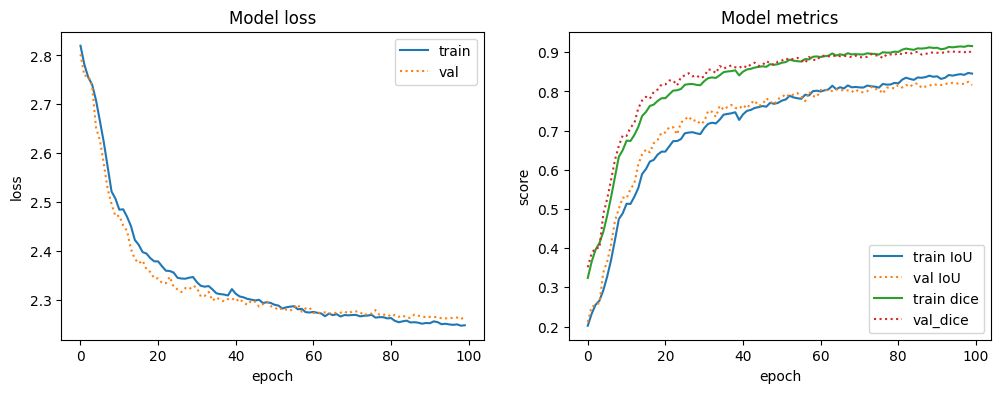

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'], linestyle='dotted')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'], linestyle='dotted')
plt.plot(H['train_DC'])
plt.plot(H['test_DC'], linestyle='dotted')
plt.title('Model metrics')
plt.ylabel('score')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [14]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [15]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (0, 0, 0))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

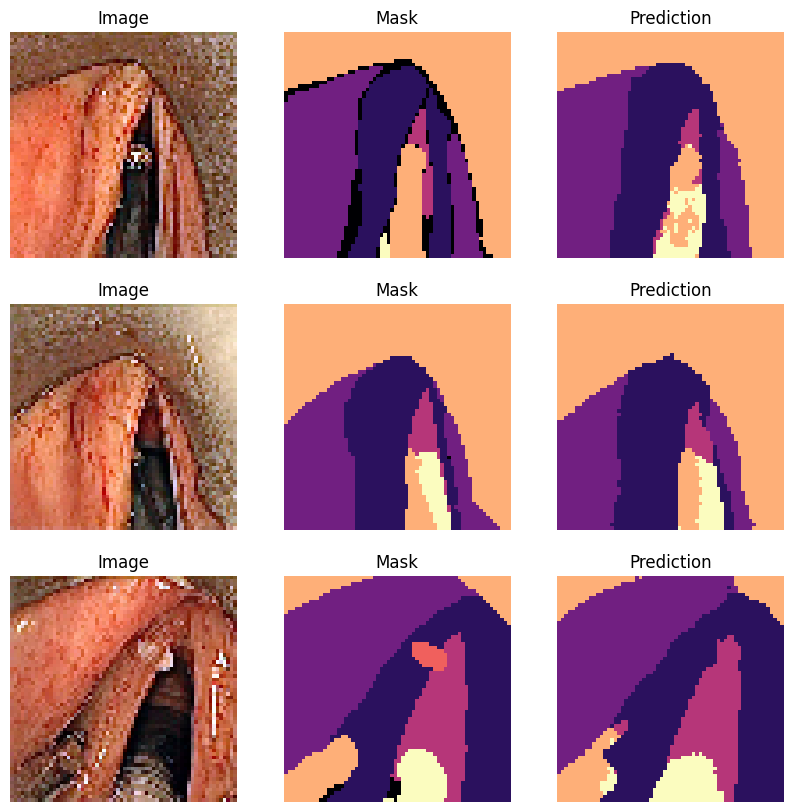

In [16]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=NUM_CLASSES-1))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=NUM_CLASSES-1))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota